# Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from processing import ProcessingTransformer
from sklearn.feature_selection import mutual_info_classif

from engineering import *


sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("../data/processed_train.csv")

# Learning data correlation and column engineering

In [3]:
def plot_corr(
    corr, threshold_up=0.8, threshold_down=0.01, threshold_sign=0.6, hue=None
):
    if hue is not None and isinstance(hue, str):
        hue = [hue]
    mask = np.triu(np.ones_like(corr, dtype=bool))
    heatmap = sns.heatmap(corr, mask=mask, linewidths=1, cmap="bwr")

    for i in range(len(corr)):
        for j in range(len(corr)):
            if i > j:
                corr_val = corr.iloc[i, j]
                if abs(corr_val) >= threshold_up:
                    heatmap.add_patch(
                        plt.Rectangle((j, i), 1, 1, fill=True, color="green")
                    )
                    plt.text(
                        j + 0.5,
                        i + 0.6,
                        f"{corr_val:1.2f}",
                        ha="center",
                        va="center",
                        fontsize=7,
                        color="white",
                    )
                elif abs(corr_val) >= threshold_sign:
                    plt.text(
                        j + 0.5,
                        i + 0.6,
                        f"{corr_val:1.2f}",
                        ha="center",
                        va="center",
                        fontsize=7,
                        color="black",
                    )

                if abs(corr_val) <= threshold_down:
                    heatmap.add_patch(
                        plt.Rectangle((j, i), 1, 1, fill=True, color="gray", alpha=0.7)
                    )
                    plt.text(
                        j + 0.5,
                        i + 0.6,
                        f"{corr_val:1.2f}",
                        ha="center",
                        va="center",
                        fontsize=7,
                        color="white",
                    )
                if hue is not None and corr.columns[i] in hue or corr.columns[j] in hue:
                    heatmap.add_patch(
                        plt.Rectangle(
                            (j, i), 1, 1, edgecolor="black", fill=False, linewidth=2.5
                        )
                    )

    return heatmap

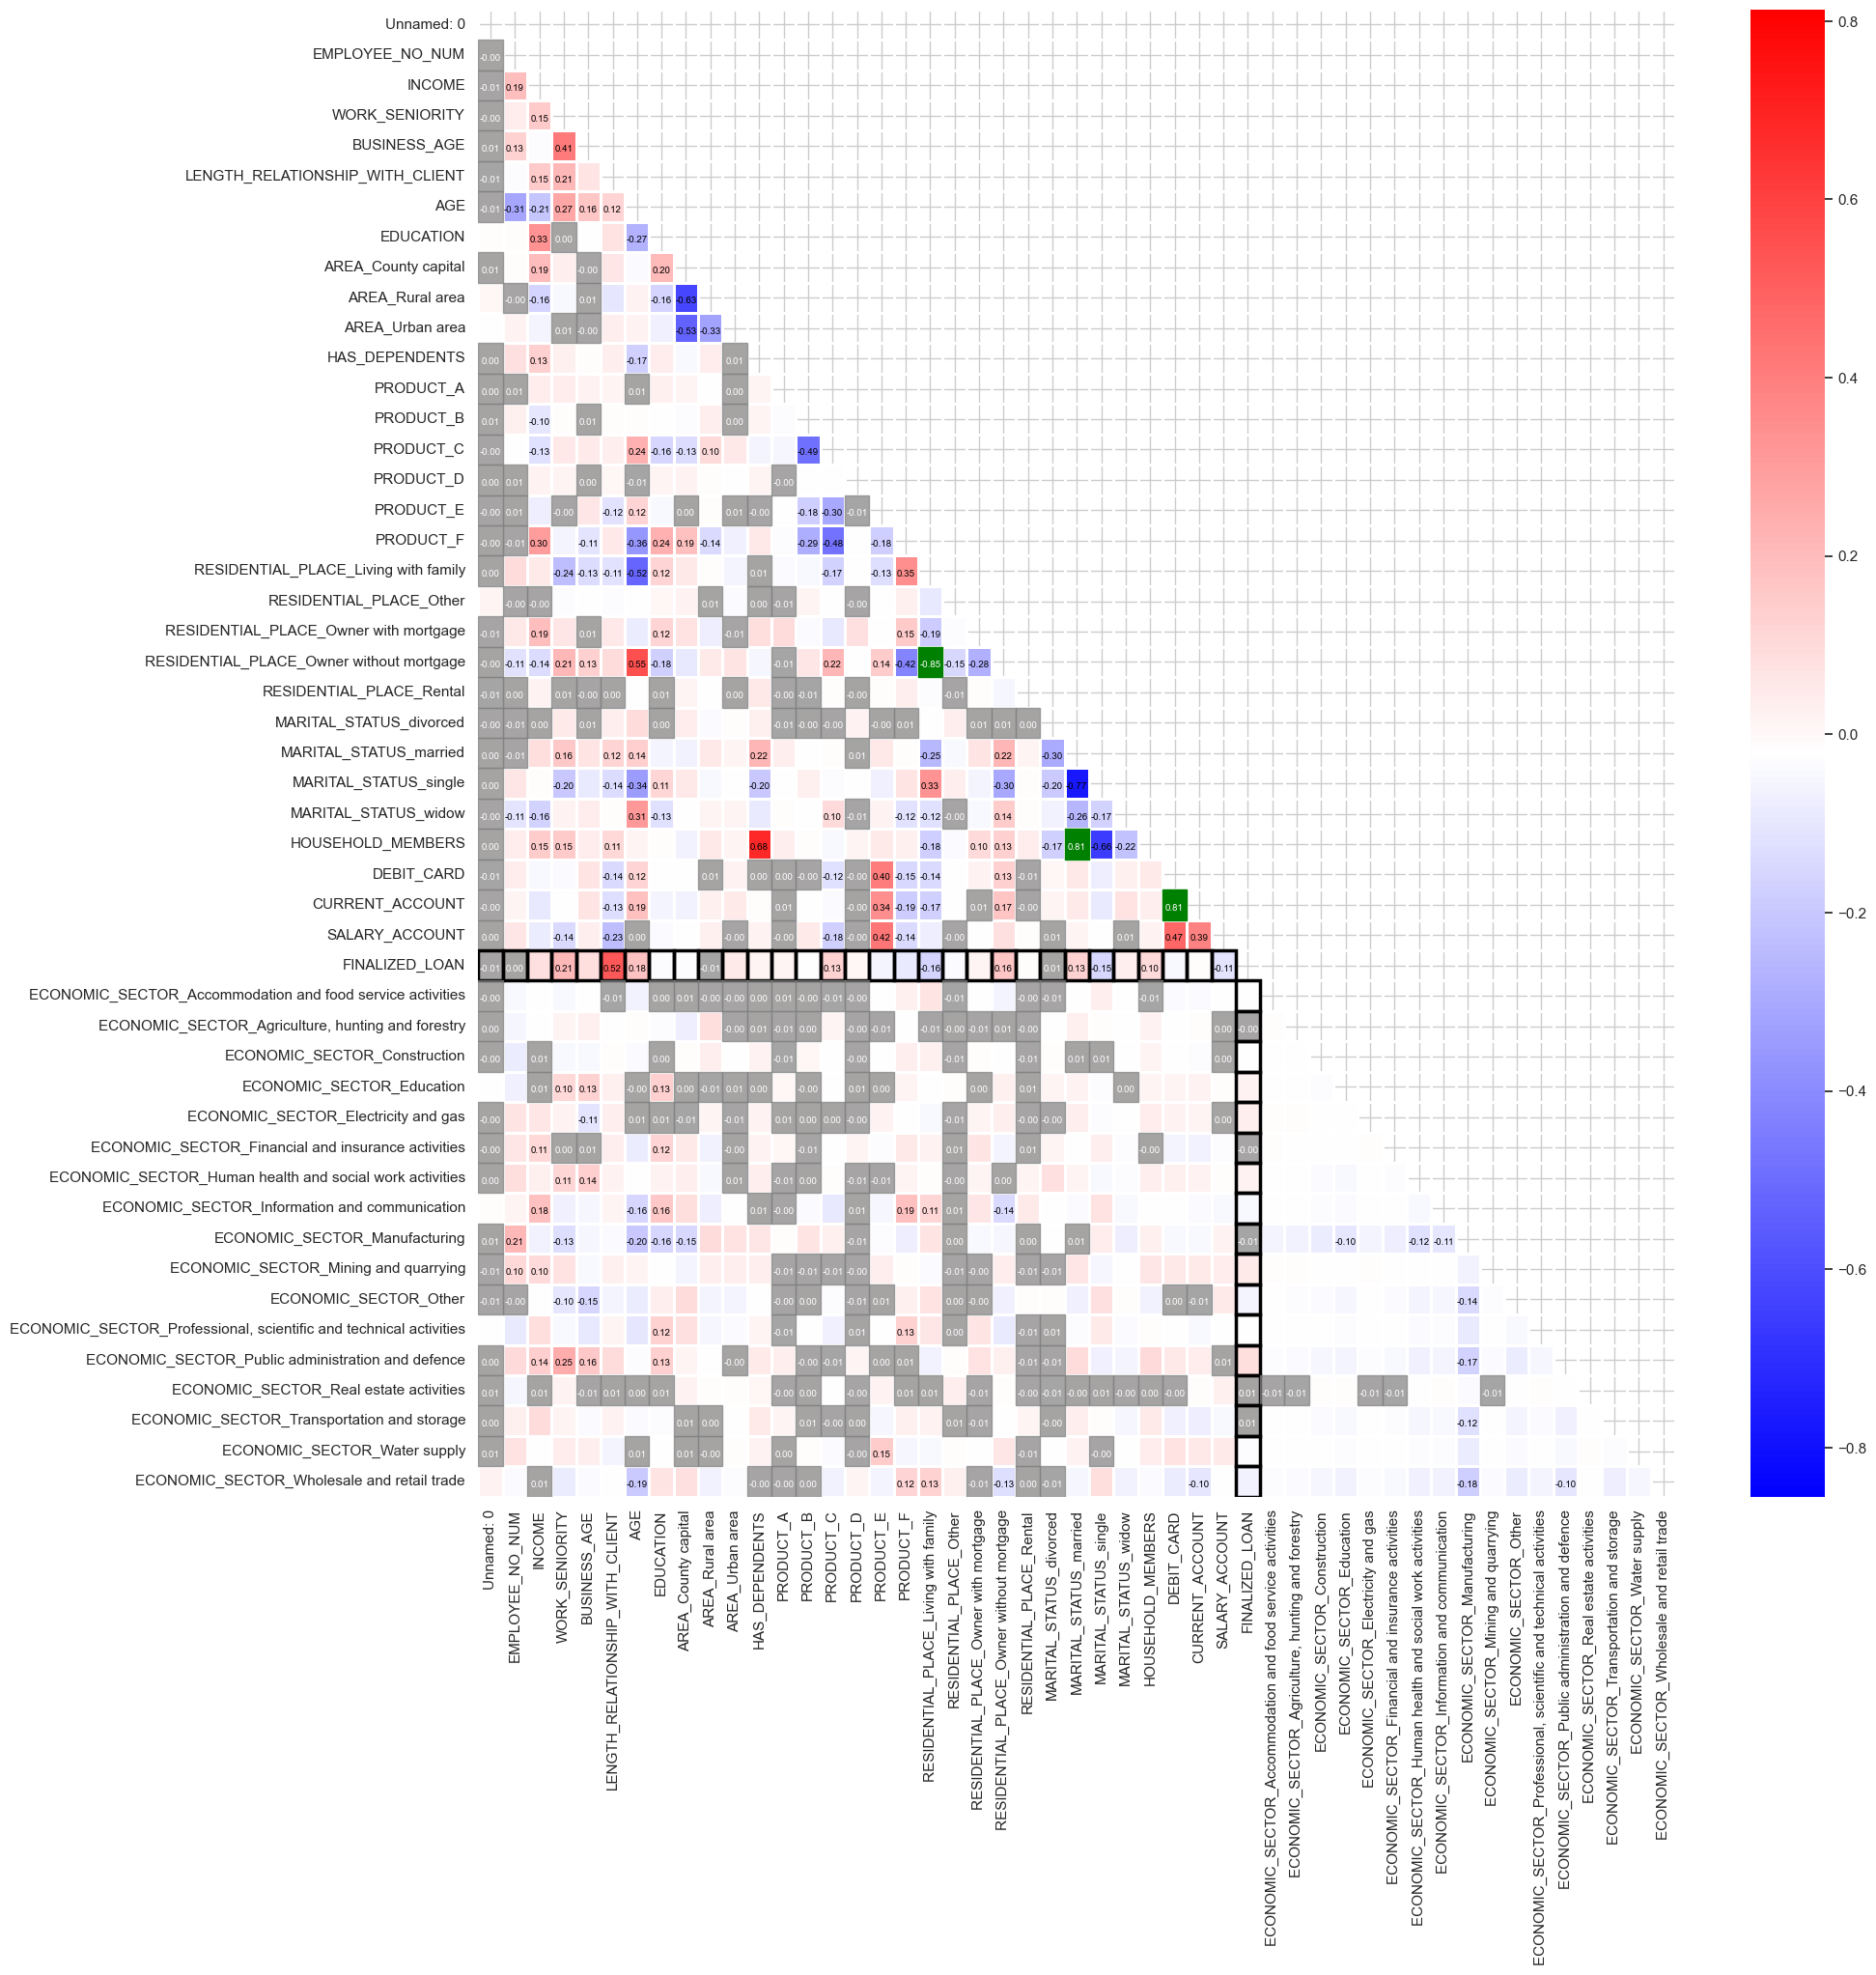

In [4]:
plt.figure(figsize=(20, 20))
corr = df.corr()
plot_corr(
    corr,
    hue=["FINALIZED_LOAN"],
    threshold_down=0.01,
    threshold_up=0.8,
    threshold_sign=0.1,
)
plt.show()

Columns that share a very high level of correlation:
* CURRENT_ACCOUNT & DEBIT_CARD: **0.81**
* HOUSEHOLD_MEMBERS & MARITAL_STATUS_maried: **0.81**
* RESIDENTAL_PLACE_Living with family & RESIDENTAL_PLACE_Owner without mortgage: **-0.85**

Some more columns with high level of correlation:
* FINALIZED_LOAN & LENGTH_RELATIONSHIP_WITH_CLIENT
* MARITAL_STATUS_married & MARITAL_STATUS_single
* RESIDENTAL_PLACE_Owner without mortgage & AGE
* HOUSEHOLD_MEMBERS & NO_OF_DEPENDENTS
* SALARY_ACCOUT & CURRENT_ACCOUT

In [5]:
def make_bool_dist_matrix(name_1, name_2):
    return pd.DataFrame(
        [
            [
                f"{len(df.iloc[np.where((df[name_1] == i) & (df[name_2] == j))]) * 100 / len(df):.3f}% ({len(df.iloc[np.where((df[name_1] == i) & (df[name_2] == j))])})"
                for i in range(2)
            ]
            for j in range(2)
        ],
        columns=[f"{name_1}_0", f"{name_1}_1"],
        index=[[f"{name_2}_0", f"{name_2}_1"]],
    )


make_bool_dist_matrix("CURRENT_ACCOUNT", "DEBIT_CARD")

,CURRENT_ACCOUNT_0,CURRENT_ACCOUNT_1
DEBIT_CARD_0,51.454% (7768),10.134% (1530)
DEBIT_CARD_1,0.000% (0),38.412% (5799)


We can see that if a person does not have an account that implies that they most surely dont have a debit card. In this situation we may want to cut down the number of possible outcomes in the matrix above. We think the best option would be to merge these two column into one like this:

Column name: HAS_CURRENT_ACCOUNT
Values:
* with debit card
* without debit card
* no

Then using one hot we will split it

In [6]:
# Create a copy of the 'CURRENT_ACCOUNT' column with a new name
df["HAS_CURRENT_ACCOUNT"] = df["CURRENT_ACCOUNT"]

# Replace boolean values with strings in the new column
df.loc[
    (df["DEBIT_CARD"] == True) & (df["CURRENT_ACCOUNT"] == True), "HAS_CURRENT_ACCOUNT"
] = "with debit card"
df.loc[
    (df["DEBIT_CARD"] == False) & (df["CURRENT_ACCOUNT"] == False),
    "HAS_CURRENT_ACCOUNT",
] = "no"

# Replace False values with 'without debit card' only if 'DEBIT_CARD' is False in the new column
df.loc[
    (df["DEBIT_CARD"] == False) & (df["CURRENT_ACCOUNT"] == True), "HAS_CURRENT_ACCOUNT"
] = "without debit card"

In [7]:
df = pd.get_dummies(df, columns=["HAS_CURRENT_ACCOUNT"])
df.drop(["CURRENT_ACCOUNT", "DEBIT_CARD"], axis=1, inplace=True)

Taking into consideration out business case we want to predict if a loan will be finalized. Here are some of indicators that may be lead to a better understanding of the data:

* LENGTH_RELATIONSHIP_WITH_CLIENT to WORK_SENIORITY ratio
* INCOME TO WORK_SENIORITY ratio
* BUSINESS_AGE to AGE ratio
* LENGTH_RELATIONSHIP_WITH_CLIENT to BUSINESS_AGE ratio
* INCOME to LENGTH_RELATION_WITH_CLIENT ratio

In [8]:
df["LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY"] = (
    df["LENGTH_RELATIONSHIP_WITH_CLIENT"] / df["WORK_SENIORITY"]
)
df["INCOME_TO_WORK_SENIORITY_RATIO"] = df["INCOME"] / df["WORK_SENIORITY"]
df["BUSINESS_AGE_TO_AGE_RATIO"] = df["BUSINESS_AGE"] / df["WORK_SENIORITY"]
df["LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE"] = (
    df["LENGTH_RELATIONSHIP_WITH_CLIENT"] / df["BUSINESS_AGE"]
)
df["INCOME_TO_LENGTH_RELATIONSHIP_WITH_CLIENT"] = (
    df["INCOME"] / df["LENGTH_RELATIONSHIP_WITH_CLIENT"]
)

Additionally we will implement a credit scoring system. There is a weighted system where we can see what features we value the most from our business perspective. Income and length relationship with client are the most important. There are some features that we believe are negative like being single from MARITAL_STATUS.


In [9]:
total_score_combinator = FeatureCorrelationEngineer(
    cols_to_combine=[
        "INCOME",
        "WORK_SENIORITY",
        "BUSINESS_AGE",
        "LENGTH_RELATIONSHIP_WITH_CLIENT",
        "AGE",
        "EDUCATION",
        "HAS_DEPENDENTS",
        "MARITAL_STATUS_married",
        "MARITAL_STATUS_single",
        "RESIDENTIAL_PLACE_Owner without mortgage",
    ],
    target_col="FINALIZED_LOAN",
    new_name="TOTAL_SCORE",
)

df = total_score_combinator.fit_transform(df)

In [10]:
total_score_combinator.weights

array([ 0.24007178,  0.78449442,  0.01632284,  5.26005219,  0.52608345,
       -2.04160981, -0.02077216,  0.46227607, -0.33512139,  1.27201294])

Normalizing Credit score was made just for conveniance, but it was not neccesary. The other engineered features weren't normalized

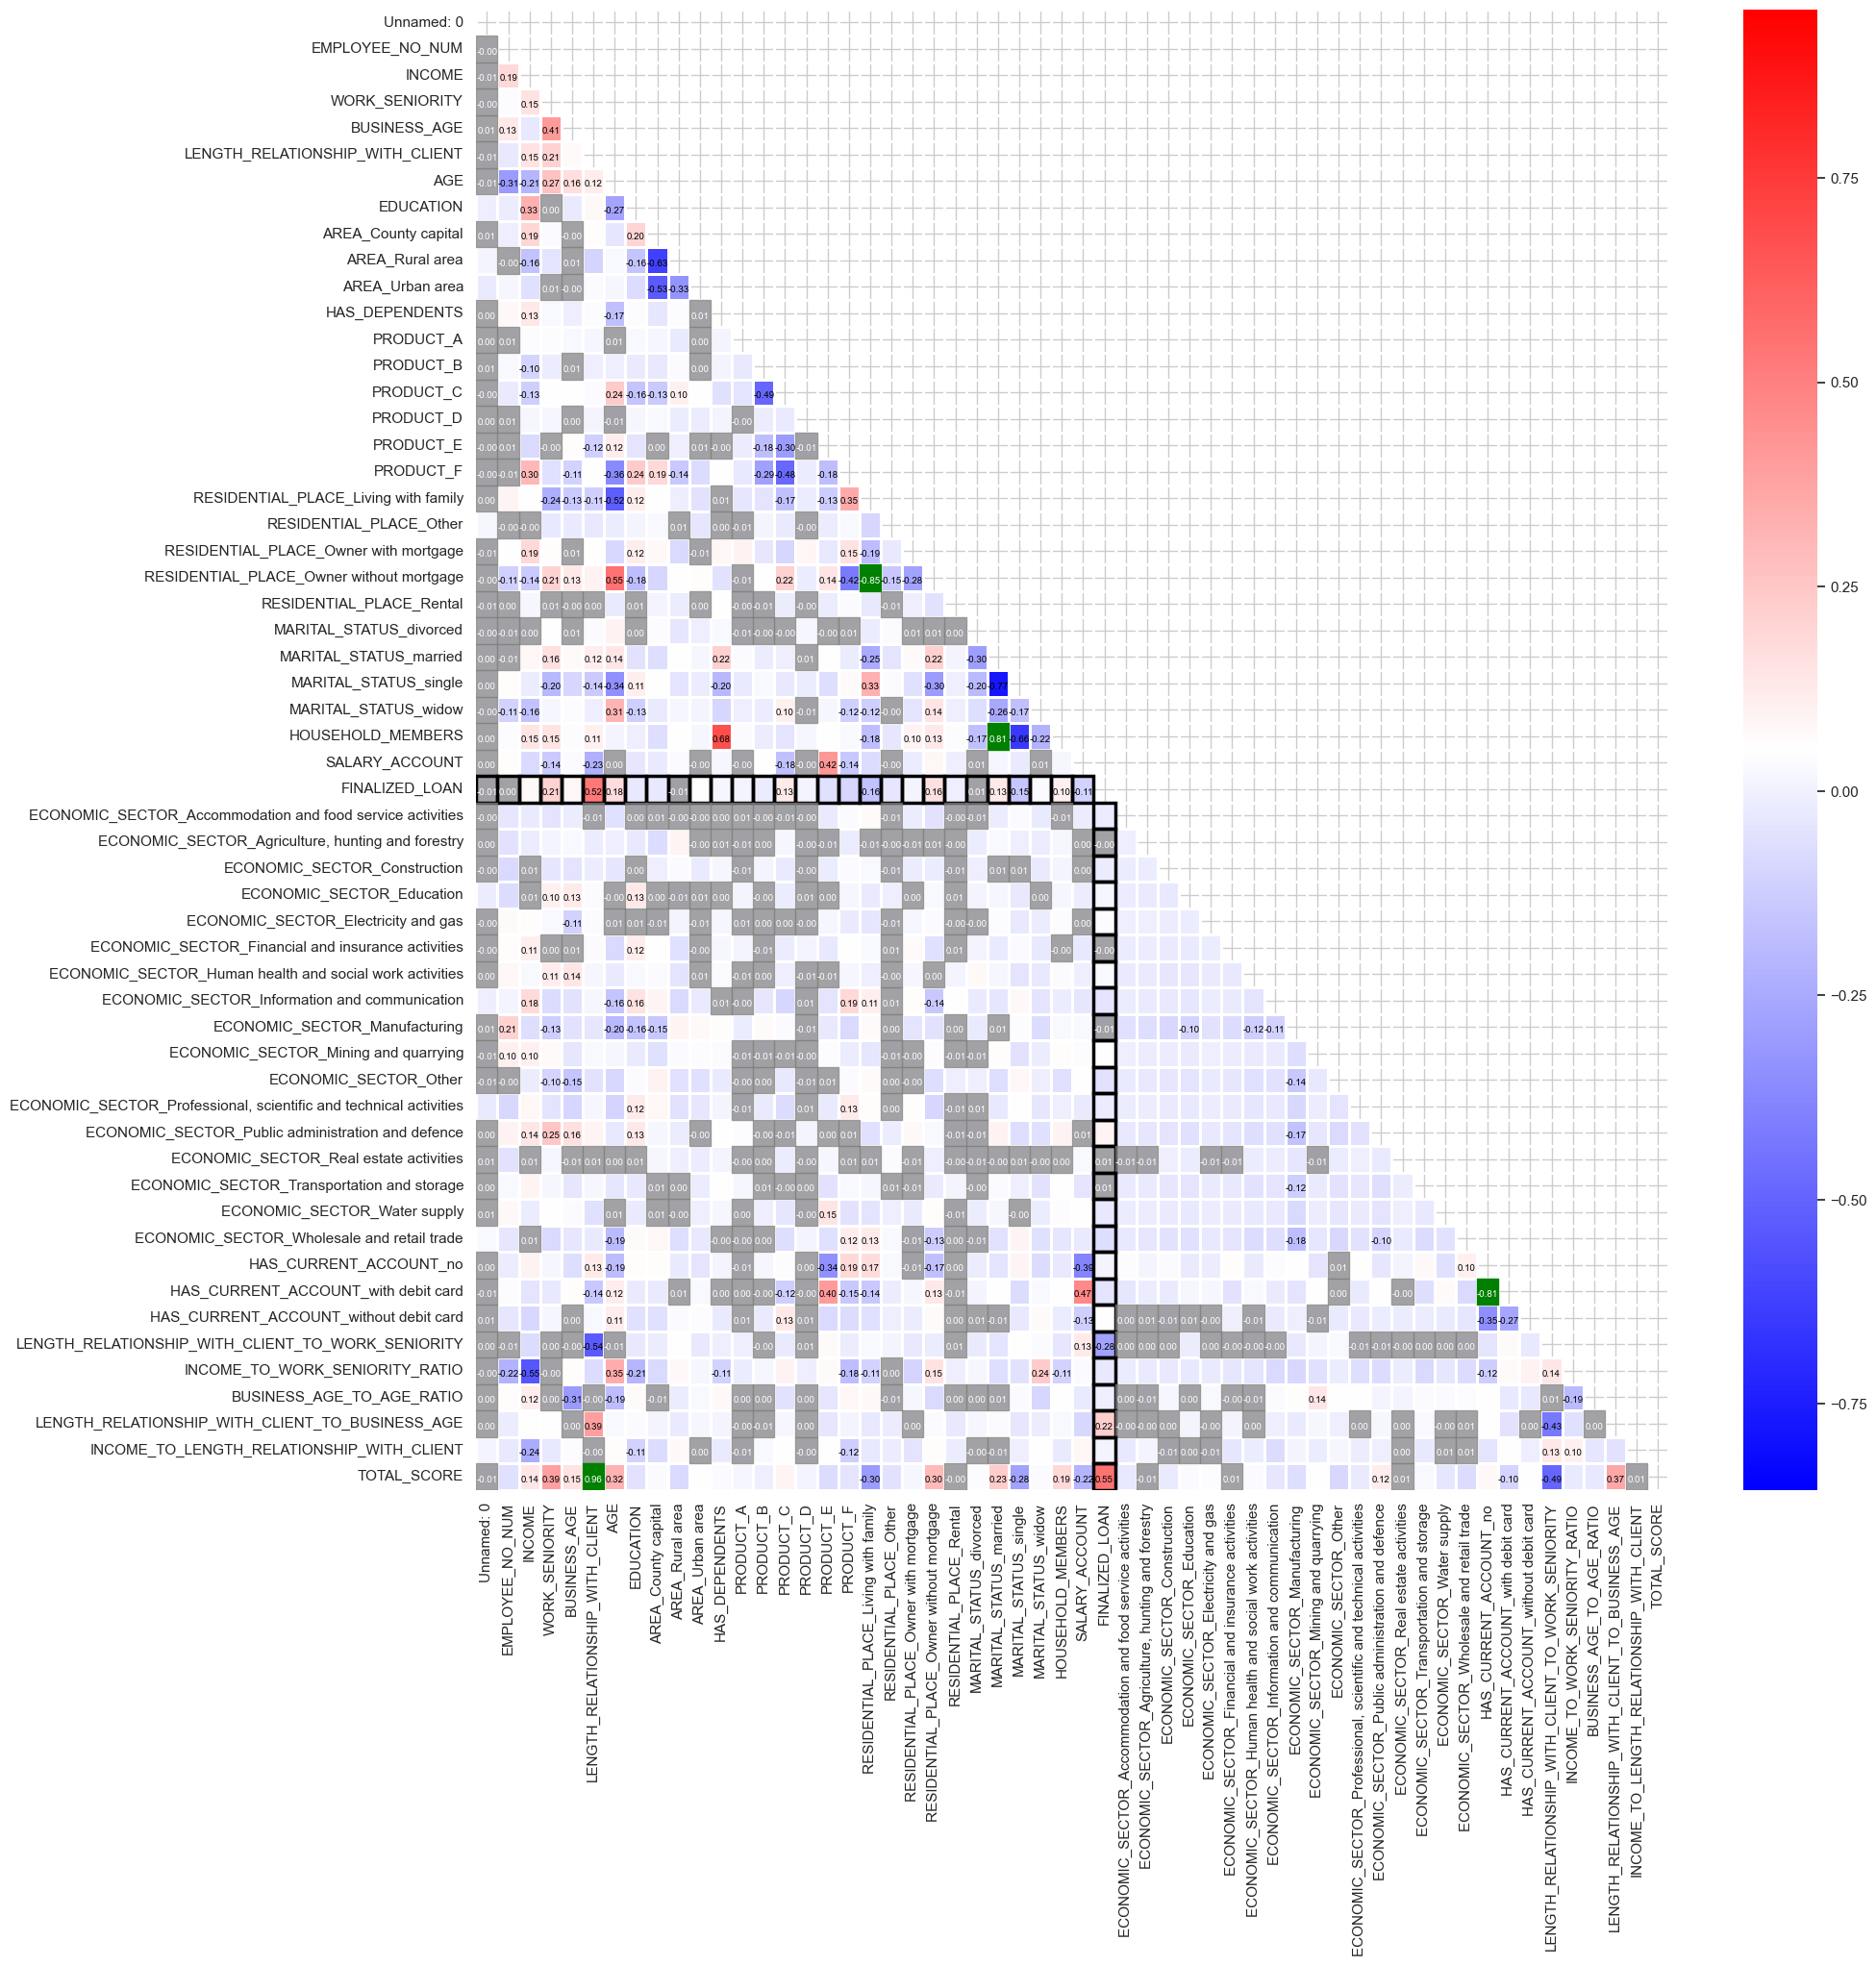

In [11]:
plt.figure(figsize=(20, 20))
corr = df.corr()
plot_corr(
    corr,
    hue=["FINALIZED_LOAN"],
    threshold_down=0.01,
    threshold_up=0.8,
    threshold_sign=0.1,
)
plt.show()

In [12]:
X = df.copy()
y = X.pop("FINALIZED_LOAN")

for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

discrete_features = X.dtypes == int

In [13]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Unnamed: 0                                                           0.446577
TOTAL_SCORE                                                          0.195518
LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY                    0.179589
LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE                      0.171483
LENGTH_RELATIONSHIP_WITH_CLIENT                                      0.167728
INCOME_TO_LENGTH_RELATIONSHIP_WITH_CLIENT                            0.065551
AGE                                                                  0.036979
BUSINESS_AGE_TO_AGE_RATIO                                            0.030432
WORK_SENIORITY                                                       0.026224
INCOME_TO_WORK_SENIORITY_RATIO                                       0.019740
RESIDENTIAL_PLACE_Living with family                                 0.018546
INCOME                                                               0.017923
MARITAL_STATUS_married                                          

<Figure size 1200x1500 with 0 Axes>

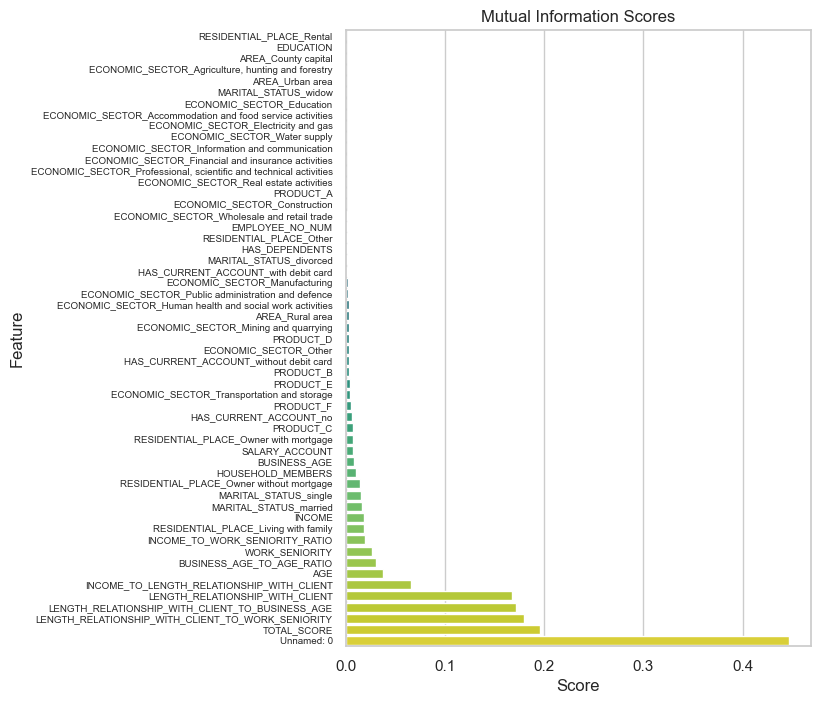

In [14]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)

    plt.figure(figsize=(6, 8))
    sns.barplot(x=scores.values, y=ticks, palette="viridis")

    plt.yticks(width, ticks, fontsize=7)
    plt.title("Mutual Information Scores")
    plt.xlabel("Score")
    plt.ylabel("Feature")
    plt.show()


plt.figure(dpi=100, figsize=(12, 15))
plot_mi_scores(mi_scores)

**Highly Informative Features:**
* LENGTH_RELATIONSHIP_WITH_CLIENT_TO_WORK_SENIORITY:   0.177917
* LENGTH_RELATIONSHIP_WITH_CLIENT_TO_BUSINESS_AGE:     0.175261
* LENGTH_RELATIONSHIP_WITH_CLIENT:                     0.173011
* CREDIT_SCORE:                                        0.127904


In [15]:
preprocessing_pipeline = joblib.load("../pipelines/processing_pipeline.joblib")

In [16]:
engineer_transform = Pipeline(
    [
        ("has_current_account", CreateHasCurrentAccountColumn()),
        ("engineered_features", CreateAdditionalFeatures()),
        ("engineered_features", total_score_combinator),
    ]
).set_output(transform="pandas")

In [17]:
feature_engineering_pipeline = EngineeringTransformer(
    (engineer_transform), preprocessing_pipeline
)

# Saving results

In [18]:
df = pd.read_csv("../data/orig_train.csv")
df_valid = pd.read_csv("../data/orig_valid.csv")

df = feature_engineering_pipeline.fit_transform(df)
df_valid = feature_engineering_pipeline.fit_transform(df_valid)

In [19]:
joblib.dump(
    feature_engineering_pipeline, "../pipelines/feature_engineering_pipeline.joblib"
)

['../pipelines/feature_engineering_pipeline.joblib']

In [20]:
df.to_csv("../data/featured_train.csv", index=False)
df_valid.to_csv("../data/featured_valid.csv", index=False)